In [38]:
import torch, tqdm
from kme.models.utils import build_kme_net
from kme.tools.config import load_config, DATASET_KEY, TRAINING_KEY, MODEL_KEY, CKPT_KEY
from kme.tools.checkpoint import load_checkpoint, save_checkpoint
from kme.data.utils import get_loaders
import torch.optim as optim
from kme.tools.training import train_routine, test_routine
from sklearn.neighbors import KDTree
import numpy as np
from matplotlib import pyplot as plt
from torch.nn import Unfold, Fold
import seaborn as sns
import captum
from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from kme.tools.interpreting import match_single_patches

In [7]:
CONFIG_FPATH = '/home/phineas/Documents/repos/kme_net/results/mnist/4/kmenet_sample_config.json'
BATCH_SIZE = 32

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
config = load_config(CONFIG_FPATH)

dataset_params = config[DATASET_KEY]
training_params = config[TRAINING_KEY]
model_params = config[MODEL_KEY]
ckpt_root = config[CKPT_KEY]

# training params
N_EPOCHS = training_params['n_epochs']
BATCH_SIZE = 2000
OPTIMIZER = training_params['optimizer']
OPTIMIZER_PARAMS = training_params['optimizer_params']
SCHEDULER = training_params['scheduler']

In [9]:
dataset_params = config[DATASET_KEY]
train_loader, valid_loader, test_loader = get_loaders(**dataset_params, batch_size=BATCH_SIZE)
kme_net = build_kme_net(model_params, device=device).to(device)

In [10]:
optimizer = getattr(optim, OPTIMIZER)(kme_net.parameters(), **OPTIMIZER_PARAMS)
scheduler = None
if SCHEDULER is not None:
    SCHEDULER_PARAMS = training_params['scheduler_params']
    scheduler = getattr(optim.lr_scheduler, SCHEDULER)(optimizer, **SCHEDULER_PARAMS)

# checkpoint and summary writer
kme_net, optimizer, scheduler, epoch = load_checkpoint(ckpt_root, kme_net, optimizer, scheduler)

In [11]:
test_loss, test_accuracy = test_routine(N_EPOCHS, kme_net, test_loader, device)

10] Loss: 0.333008, Accuracy 0.887700


In [12]:
# get train samples and patches representations
kme_net.eval()
for (imgs, ys) in tqdm.tqdm(train_loader):
    imgs_numpy = imgs.detach().numpy()
    patch_representations = kme_net._feat_net.process_samples(imgs)
    break
patch_representations_numpy = patch_representations.detach().numpy()

  0%|          | 0/27 [00:03<?, ?it/s]


In [13]:
sample_repr = patch_representations.sum(dim=1)
sample_repr_numpy = sample_repr.detach().numpy()
sample_norms = np.linalg.norm(sample_repr_numpy, axis=1, keepdims=True)
sample_repr_numpy_normalized = sample_repr_numpy / np.linalg.norm(sample_repr_numpy, axis=1, keepdims=True)

In [14]:
kdtree = KDTree(sample_repr_numpy, leaf_size=40)
kdtree_cosine = KDTree(sample_repr_numpy_normalized, leaf_size=40)

In [15]:
def show_closest_samples(idx, n_closest, cosine=False):
    curr_sample = imgs_numpy[idx, 0]
    if not cosine:
        dists, ind = kdtree.query(sample_repr_numpy[idx:idx+1], n_closest)
    else:
        dists, ind = kdtree_cosine.query(sample_repr_numpy[idx:idx+1], n_closest)
    for i in range(0, n_closest):
        plt.figure(i)
        plt.title('Sample {}: Distance {:.2f}, RelDist {:.2f}'.format(ind[0,i], dists[0,i], dists[0,i]/sample_norms[idx,0]))
        plt.imshow(imgs_numpy[ind[0, i], 0], cmap='gray')

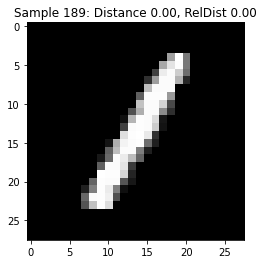

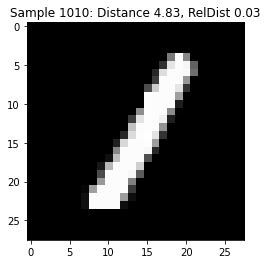

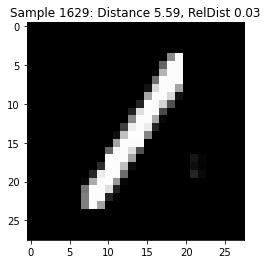

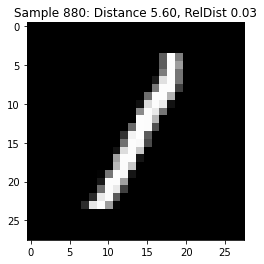

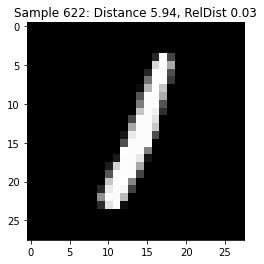

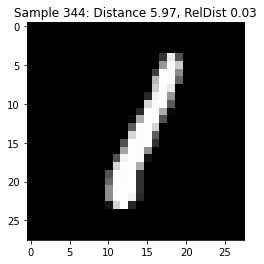

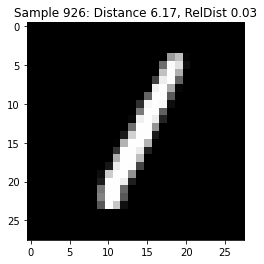

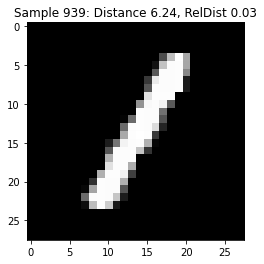

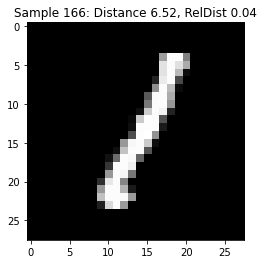

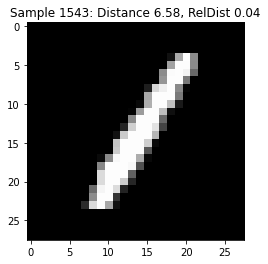

In [16]:
show_closest_samples(189, 10, cosine=False)

In [17]:
patches_kdtrees = []
patches_kdtrees_cosine = []
for i in range(49):
    curr_patches = patch_representations_numpy[:, i, :]
    curr_patches_cosine = curr_patches / np.linalg.norm(curr_patches, axis=1, keepdims=True)
    patches_kdtrees.append(KDTree(curr_patches, leaf_size=40))
    patches_kdtrees_cosine.append(KDTree(curr_patches_cosine, leaf_size=40))

In [18]:
def patch_image(img):
    n_batches = len(img)
    unfold = Unfold(4, stride=4, padding=0)
    patched_img = unfold(img).transpose(1, 2).reshape(n_batches, 49, 1, 4, 4)
    return patched_img

def fold_img(patches):
    n_batches = len(patches)
    fold = Fold((28, 28), (4, 4), padding=0, stride=4)
    patches = patches.reshape(n_batches, 49, 16).transpose(1, 2)
    img = fold(patches)
    return img

def patch_image_from_another_image(img1, img2, patch_idx):
    unfold = Unfold(4, stride=4, padding=0)
    patched_img1 = patch_image(img1)
    patched_img2 = patch_image(img2)
    patched_img1[:, patch_idx, :, :, :] = patched_img2[:, patch_idx, :, :, :]
    return fold_img(patched_img1)

In [19]:
def show_closest_patch(idx, patch_idx, n_closest, cosine=False, only_last=False):
    curr_patch = patch_representations_numpy[idx, patch_idx]
    if not cosine:
        dists, ind = patches_kdtrees[patch_idx].query(patch_representations_numpy[idx:idx+1, patch_idx], n_closest)
    else:
        dists, ind = patches_kdtrees_cosine[patch_idx].query(patch_representations_numpy[idx:idx+1, patch_idx], n_closest)
    plt.figure(1)
    plt.imshow(imgs_numpy[idx, 0], cmap='gray', vmin=0., vmax=1.)
    ref_img = imgs[idx:idx+1].clone()
    figure_idx = 1
    if only_last:
        dists = dists[:, -2:]
        ind = ind[:, -2:]
        n_closest = 2
    for i in range(1, n_closest):
        figure_idx += 1
        plt.figure(figure_idx)
        print(dists[0, i])
        curr_img = imgs[ind[0, i]:ind[0, i]+1]
        curr_img = patch_image_from_another_image(ref_img, curr_img, patch_idx)
        plt.imshow(curr_img[0, 0].detach().numpy(), cmap='gray')
        figure_idx += 1
        plt.figure(figure_idx)
        plt.imshow(-imgs_numpy[idx, 0] + curr_img[0, 0].detach().numpy(), cmap='gray')
        print(kme_net(ref_img))
        print(kme_net(ref_img).argmax())
        print(kme_net(curr_img))
        print(kme_net(curr_img).argmax())

17.422249497561157
tensor([[-3.0940,  1.4406, -1.7764, -0.5005,  1.4115, -2.7571, -5.6823,  8.2572,
         -0.5505,  6.2385]], grad_fn=<AddmmBackward>)
tensor(7)
tensor([[-3.8924,  0.2418, -0.3297,  1.3225,  0.9848,  0.7740, -3.9405,  5.0473,
         -1.2846,  4.3474]], grad_fn=<AddmmBackward>)
tensor(7)


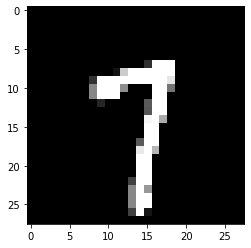

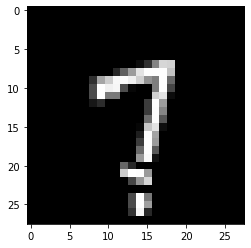

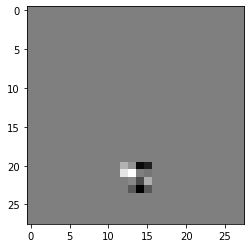

In [20]:
show_closest_patch(547, 38, 2000, cosine=False, only_last=True)

In [21]:
# 503
# 902
# 403
IDX = 362
curr_repr = patch_representations_numpy[IDX] 

In [22]:
norms = np.linalg.norm(curr_repr, axis=1)
normalized_norms = norms/np.max(norms)
ordered_norms = normalized_norms.argsort()[::-1]
importance_patches = np.zeros((1,49, 16))
for i in ordered_norms:
    importance_patches[0, i, :] = normalized_norms[i]
fold = Fold((28, 28), (4, 4), padding=0, stride=4)
importance_patches = torch.FloatTensor(importance_patches).transpose(1,2)
curr_img = fold(importance_patches)[0].detach().numpy()

In [23]:
def attribute_image_features(algorithm, input, **kwargs):
    kme_net.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=kme_net(input).argmax(),
                                              **kwargs
                                             )
    return tensor_attributions

input = imgs[IDX:IDX+1]

ig = IntegratedGradients(kme_net)
attr_ig, _ = attribute_image_features(ig, input, baselines=torch.ones(input.shape)*0.5, return_convergence_delta=True)
attr_ig = attr_ig.squeeze().cpu().detach().numpy()

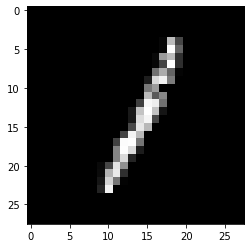

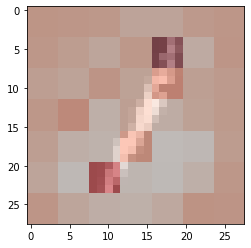

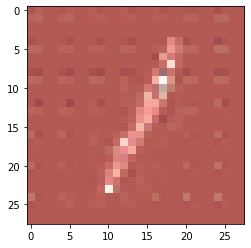

In [24]:
plt.figure(1)
plt.imshow(imgs_numpy[IDX, 0], cmap='gray')

plt.figure(2)
plt.imshow(imgs_numpy[IDX, 0], cmap='gray', alpha=0.5)
plt.imshow(curr_img[0], cmap='Reds', alpha=0.5)

plt.figure(3)
plt.imshow(imgs_numpy[IDX, 0], cmap='gray', alpha=0.5)
plt.imshow(attr_ig, cmap='Reds', alpha=0.5)

In [25]:
Q, R = np.linalg.qr(curr_repr[ordered_norms].T)
np.abs(np.diagonal(R)).argsort()

array([46, 45, 47, 48, 41, 39, 40, 42, 33, 35, 31, 32, 38, 29, 36, 30, 34,
       27, 25, 24, 22, 23, 17, 20, 18, 21, 19, 44, 43, 15, 16, 37, 14, 13,
       12, 11, 28, 26, 10,  7,  9,  6,  3,  5,  8,  4,  2,  1,  0])

/home/phineas/anaconda3/envs/kme_net/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


<Figure size 432x288 with 0 Axes>

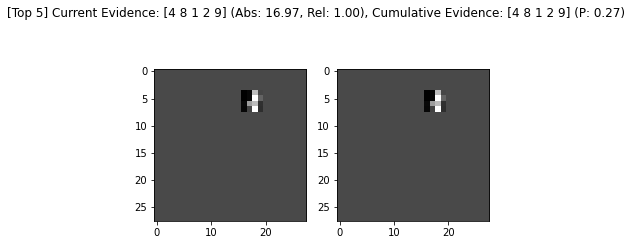

<Figure size 432x288 with 0 Axes>

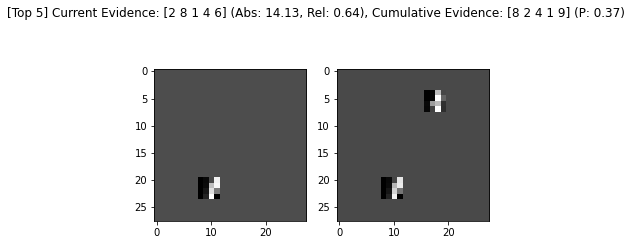

<Figure size 432x288 with 0 Axes>

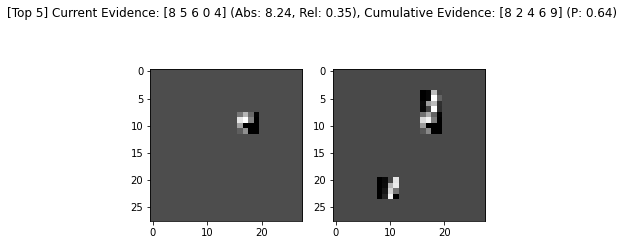

<Figure size 432x288 with 0 Axes>

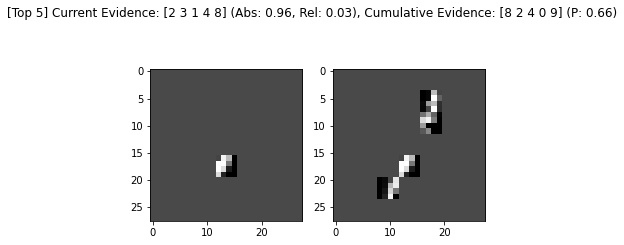

<Figure size 432x288 with 0 Axes>

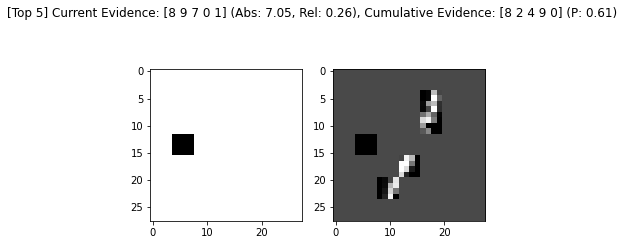

<Figure size 432x288 with 0 Axes>

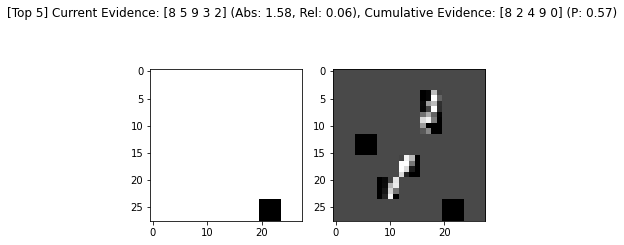

<Figure size 432x288 with 0 Axes>

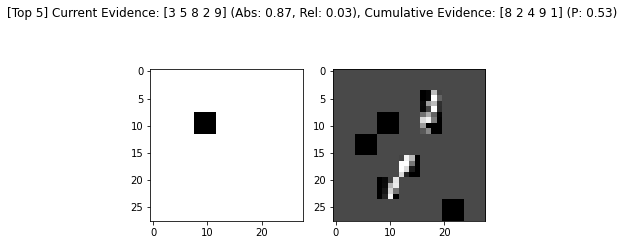

<Figure size 432x288 with 0 Axes>

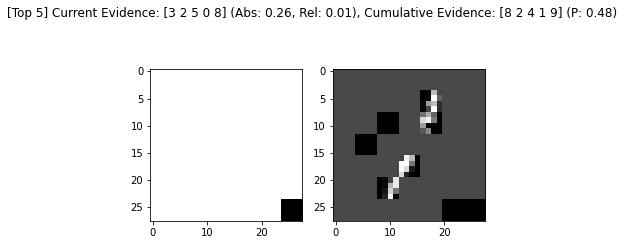

<Figure size 432x288 with 0 Axes>

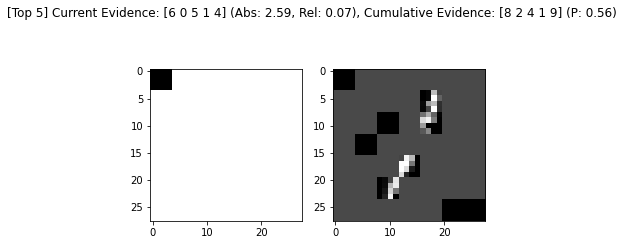

<Figure size 432x288 with 0 Axes>

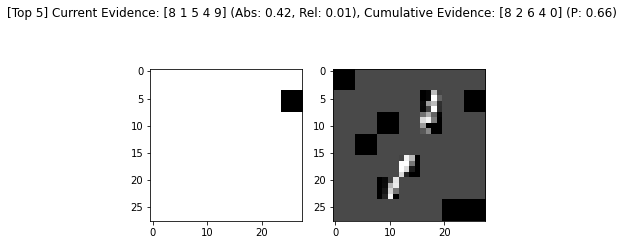

<Figure size 432x288 with 0 Axes>

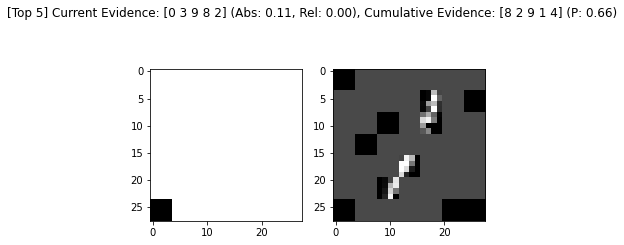

<Figure size 432x288 with 0 Axes>

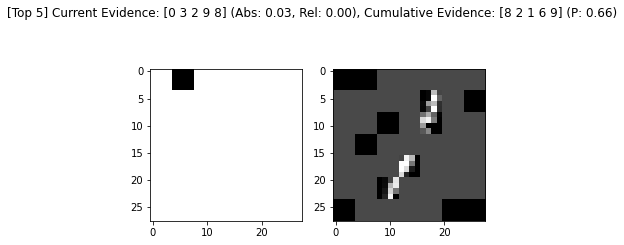

<Figure size 432x288 with 0 Axes>

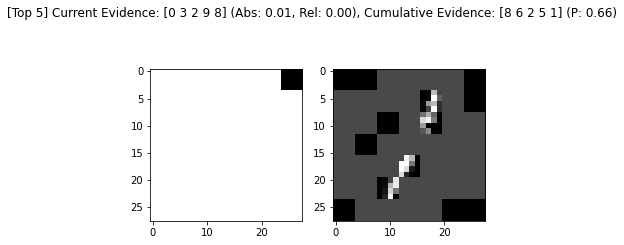

<Figure size 432x288 with 0 Axes>

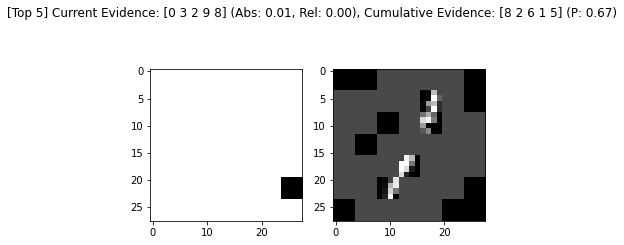

<Figure size 432x288 with 0 Axes>

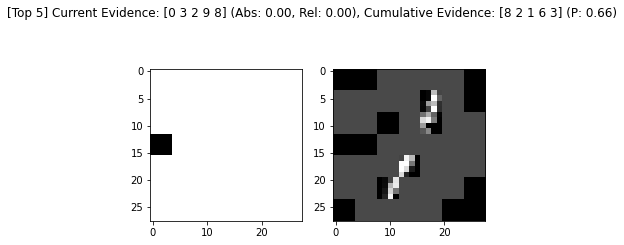

<Figure size 432x288 with 0 Axes>

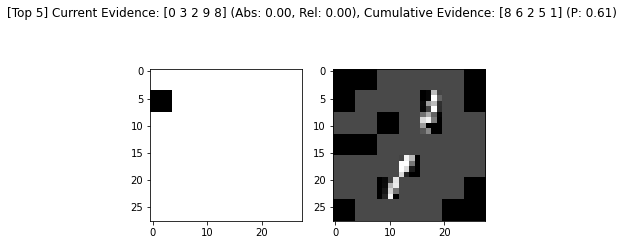

<Figure size 432x288 with 0 Axes>

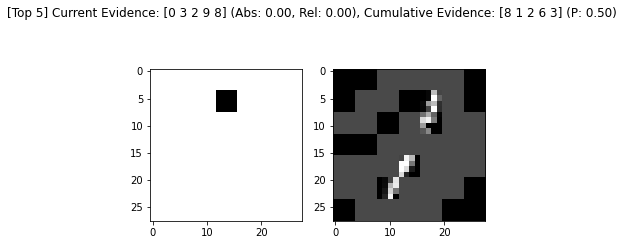

<Figure size 432x288 with 0 Axes>

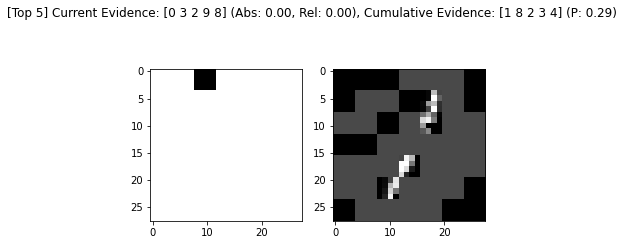

<Figure size 432x288 with 0 Axes>

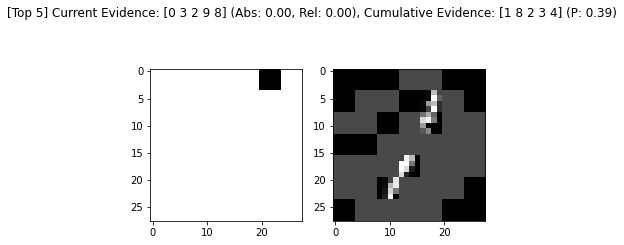

<Figure size 432x288 with 0 Axes>

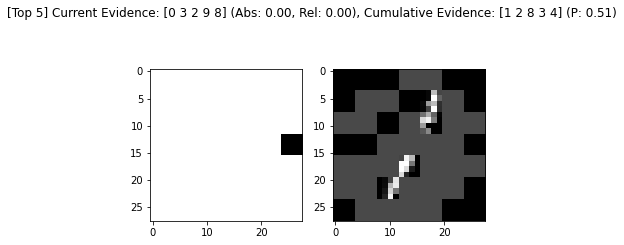

<Figure size 432x288 with 0 Axes>

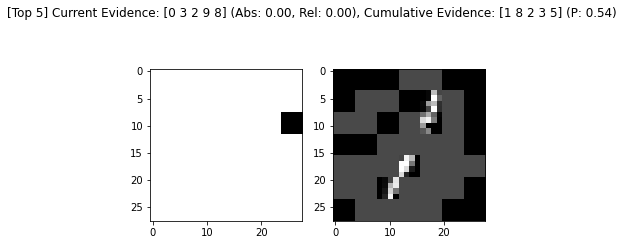

<Figure size 432x288 with 0 Axes>

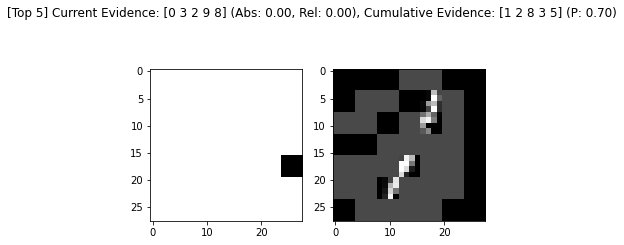

<Figure size 432x288 with 0 Axes>

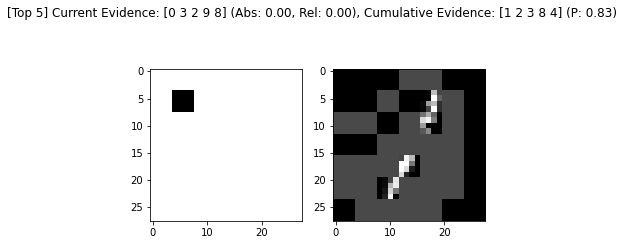

<Figure size 432x288 with 0 Axes>

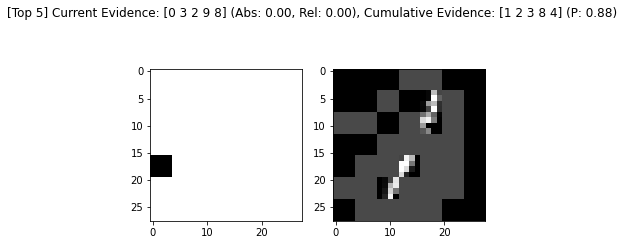

<Figure size 432x288 with 0 Axes>

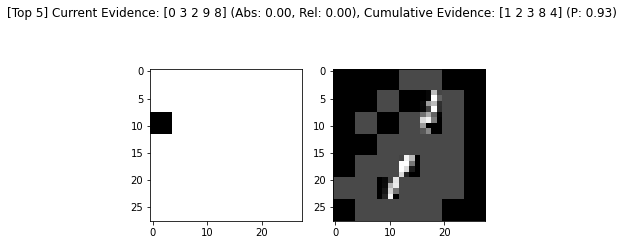

<Figure size 432x288 with 0 Axes>

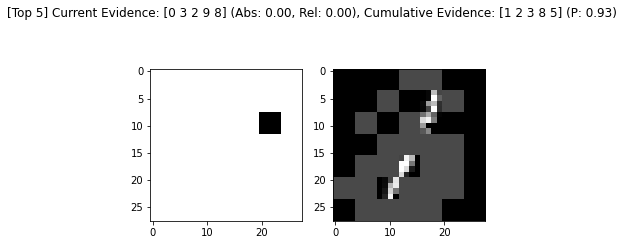

<Figure size 432x288 with 0 Axes>

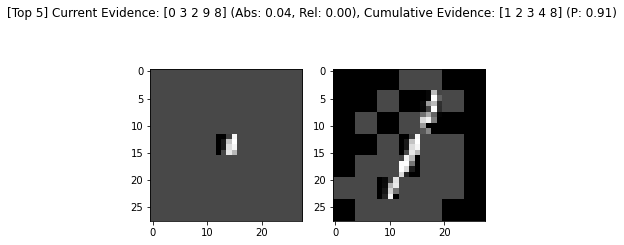

<Figure size 432x288 with 0 Axes>

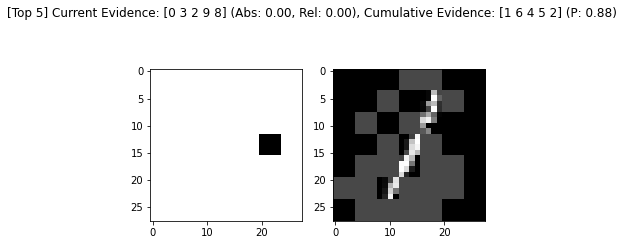

<Figure size 432x288 with 0 Axes>

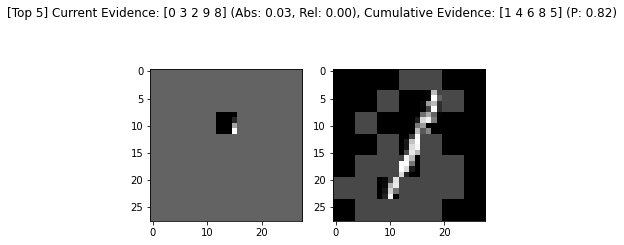

<Figure size 432x288 with 0 Axes>

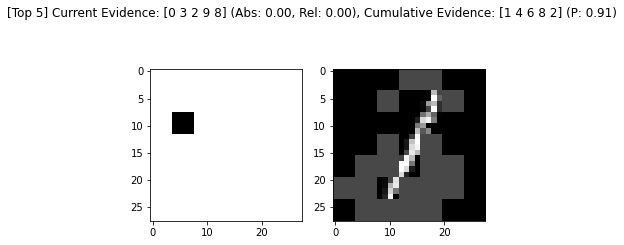

<Figure size 432x288 with 0 Axes>

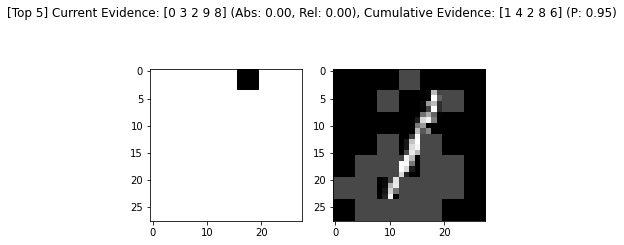

<Figure size 432x288 with 0 Axes>

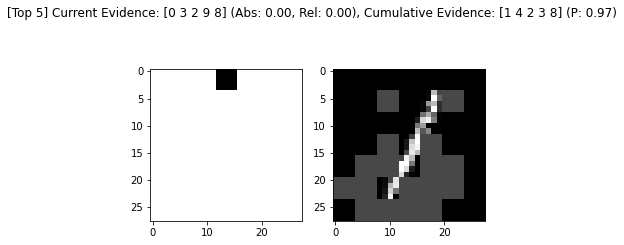

<Figure size 432x288 with 0 Axes>

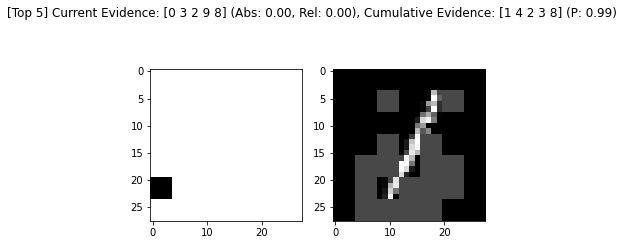

<Figure size 432x288 with 0 Axes>

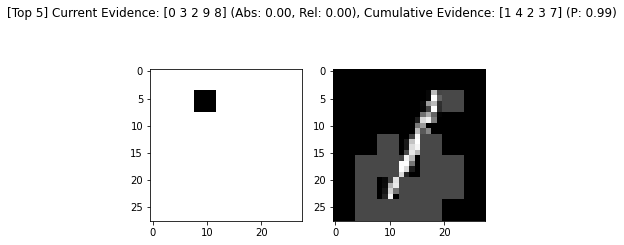

<Figure size 432x288 with 0 Axes>

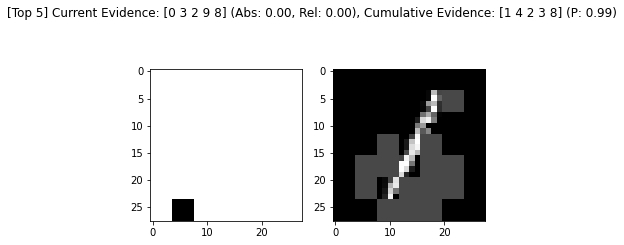

<Figure size 432x288 with 0 Axes>

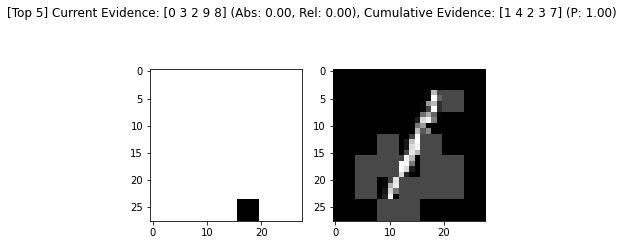

<Figure size 432x288 with 0 Axes>

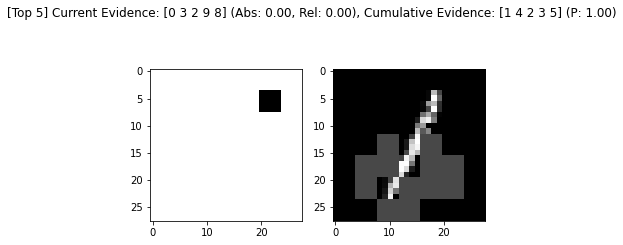

<Figure size 432x288 with 0 Axes>

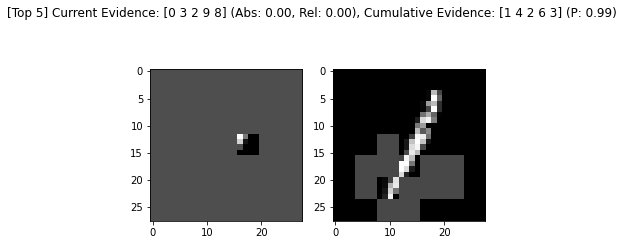

<Figure size 432x288 with 0 Axes>

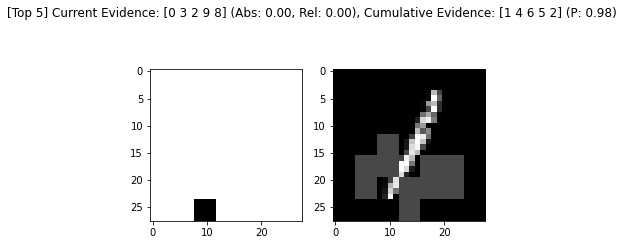

<Figure size 432x288 with 0 Axes>

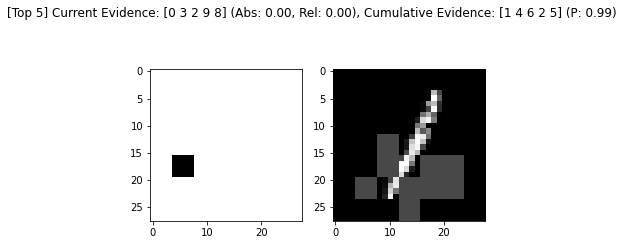

<Figure size 432x288 with 0 Axes>

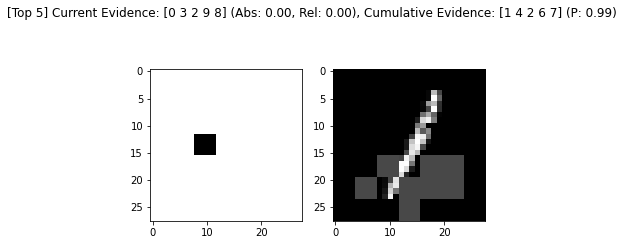

<Figure size 432x288 with 0 Axes>

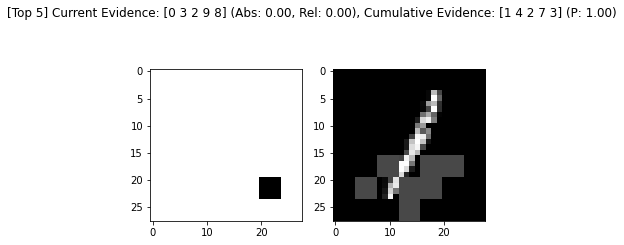

<Figure size 432x288 with 0 Axes>

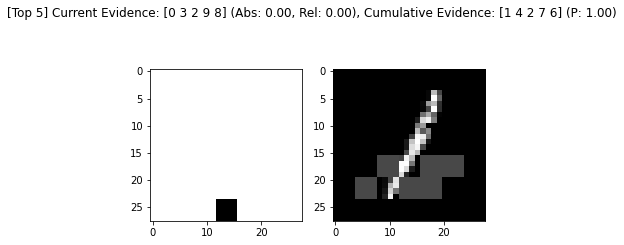

<Figure size 432x288 with 0 Axes>

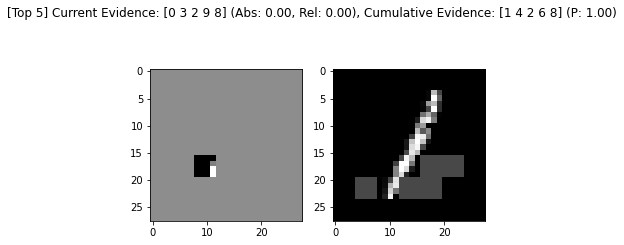

<Figure size 432x288 with 0 Axes>

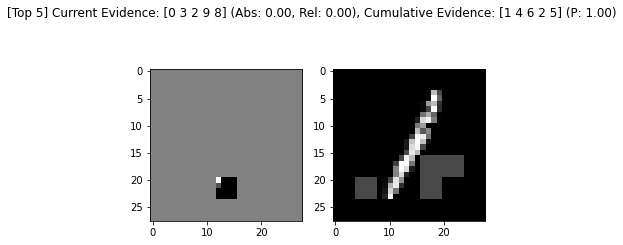

<Figure size 432x288 with 0 Axes>

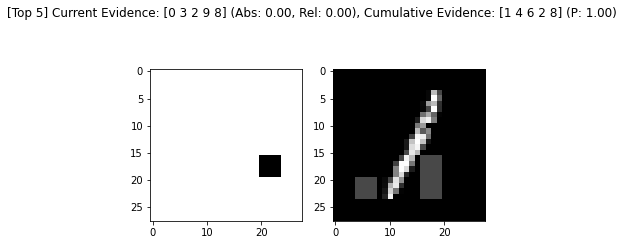

<Figure size 432x288 with 0 Axes>

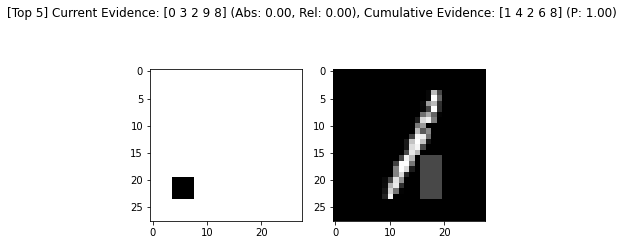

<Figure size 432x288 with 0 Axes>

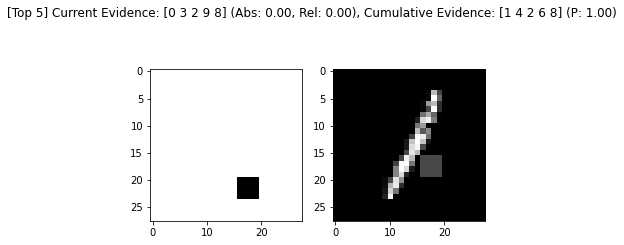

<Figure size 432x288 with 0 Axes>

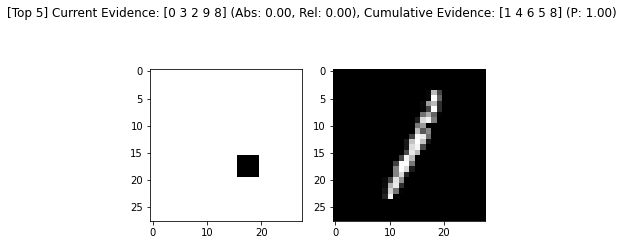

In [26]:
image = torch.ones((1, 49, 1, 4, 4))*0.5
ref_img = imgs[IDX:IDX+1]
patched_ref = patch_image(ref_img)
for i in range(Q.shape[1]):
    isolated_image = torch.ones((1, 49, 1, 4, 4))*0.5
    curr_info = kme_net._classifier(torch.FloatTensor(Q[:, i].T*R[i,i]).unsqueeze(0))
    curr_info = curr_info.topk(5).indices[0].detach().numpy()
    cum_repr = np.sum(curr_repr[ordered_norms[:i+1],:], axis=0)
    n = np.linalg.norm(cum_repr)
    cum_info = kme_net._classifier(torch.FloatTensor(np.sum(curr_repr[ordered_norms[:i+1],:], axis=0)).unsqueeze(0))
    odds_ratio = torch.nn.functional.softmax(cum_info).max()
    cum_info = cum_info.topk(5).indices[0].detach().numpy()
    image[0,ordered_norms[i],:, :, :] = patched_ref[0,ordered_norms[i],:, :, :]
    isolated_image[0,ordered_norms[i],:, :, :] = patched_ref[0,ordered_norms[i],:, :, :]
    plt.figure(i+1)
    fig, axis = plt.subplots(1, 2)
    fig.suptitle('[Top 5] Current Evidence: {} (Abs: {:.2f}, Rel: {:.2f}), Cumulative Evidence: {} (P: {:.2f})'.format(curr_info, np.abs(R[i,i]), np.abs(R[i,i])/n ,cum_info, odds_ratio))
    axis[0].imshow(fold_img(isolated_image)[0,0].detach().numpy(), cmap='gray')
    axis[1].imshow(fold_img(image)[0,0].detach().numpy(), cmap='gray')
    plt.show()

<Figure size 432x288 with 0 Axes>

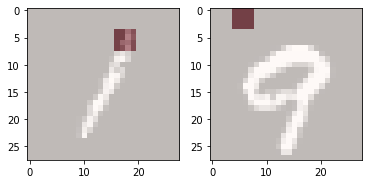

<Figure size 432x288 with 0 Axes>

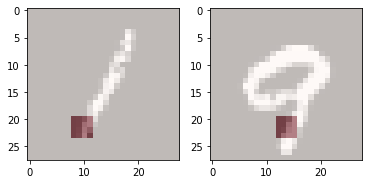

<Figure size 432x288 with 0 Axes>

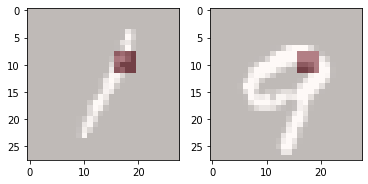

<Figure size 432x288 with 0 Axes>

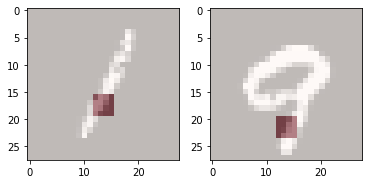

<Figure size 432x288 with 0 Axes>

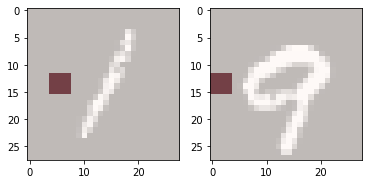

<Figure size 432x288 with 0 Axes>

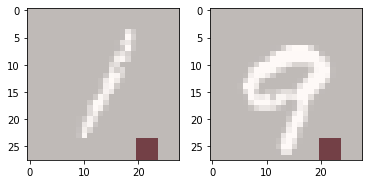

<Figure size 432x288 with 0 Axes>

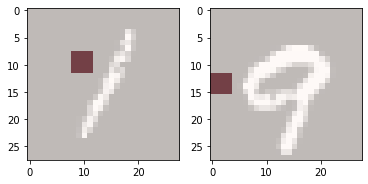

<Figure size 432x288 with 0 Axes>

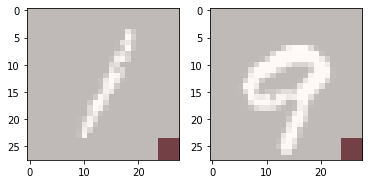

<Figure size 432x288 with 0 Axes>

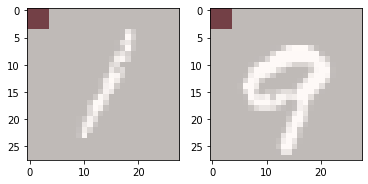

<Figure size 432x288 with 0 Axes>

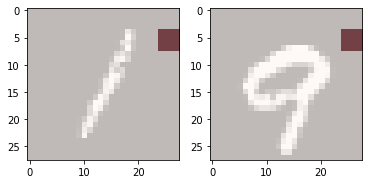

<Figure size 432x288 with 0 Axes>

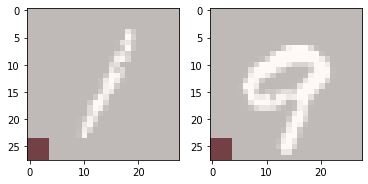

<Figure size 432x288 with 0 Axes>

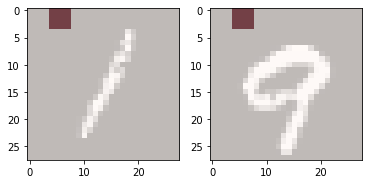

<Figure size 432x288 with 0 Axes>

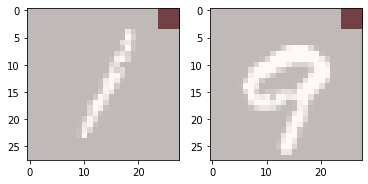

<Figure size 432x288 with 0 Axes>

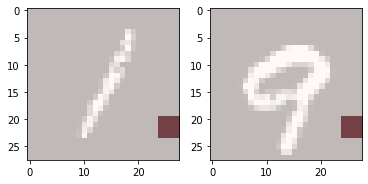

<Figure size 432x288 with 0 Axes>

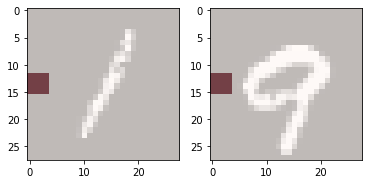

<Figure size 432x288 with 0 Axes>

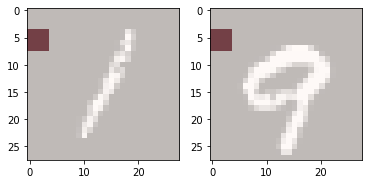

<Figure size 432x288 with 0 Axes>

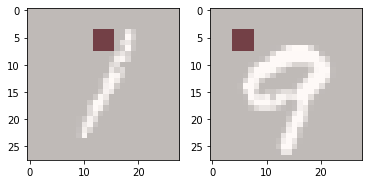

<Figure size 432x288 with 0 Axes>

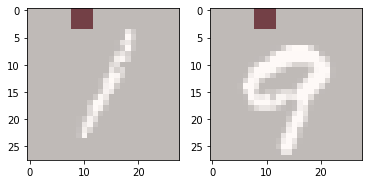

<Figure size 432x288 with 0 Axes>

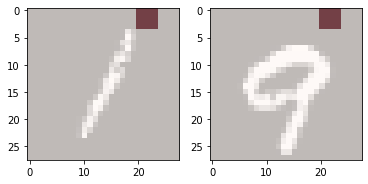

<Figure size 432x288 with 0 Axes>

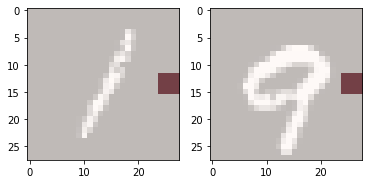

<Figure size 432x288 with 0 Axes>

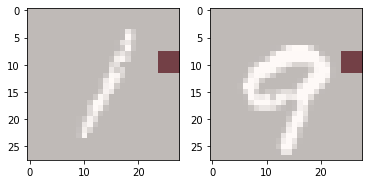

<Figure size 432x288 with 0 Axes>

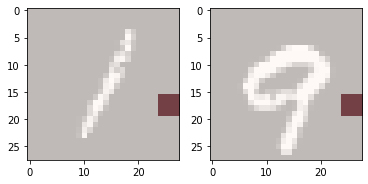

<Figure size 432x288 with 0 Axes>

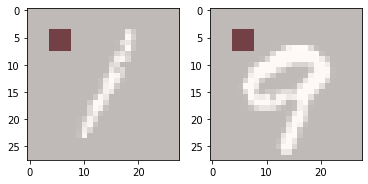

<Figure size 432x288 with 0 Axes>

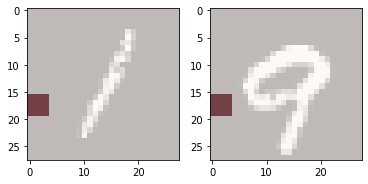

<Figure size 432x288 with 0 Axes>

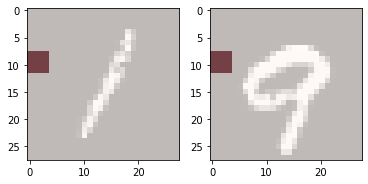

<Figure size 432x288 with 0 Axes>

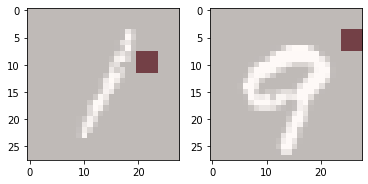

<Figure size 432x288 with 0 Axes>

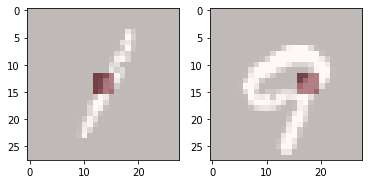

<Figure size 432x288 with 0 Axes>

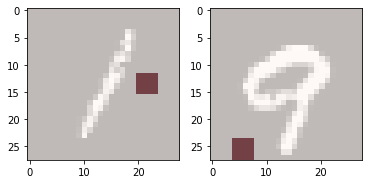

<Figure size 432x288 with 0 Axes>

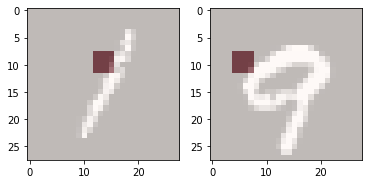

<Figure size 432x288 with 0 Axes>

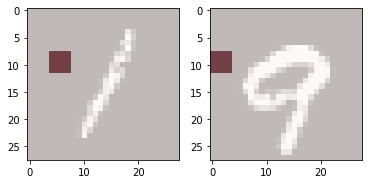

<Figure size 432x288 with 0 Axes>

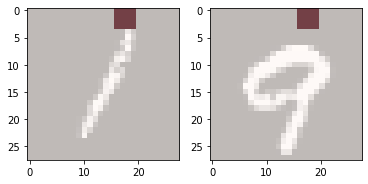

<Figure size 432x288 with 0 Axes>

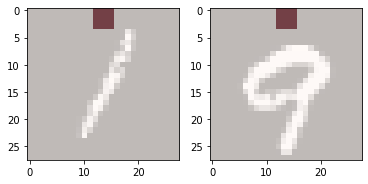

<Figure size 432x288 with 0 Axes>

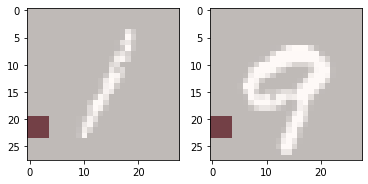

<Figure size 432x288 with 0 Axes>

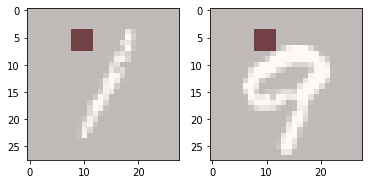

<Figure size 432x288 with 0 Axes>

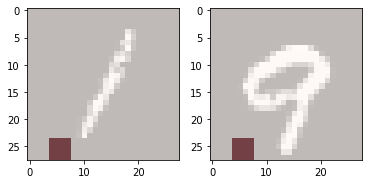

<Figure size 432x288 with 0 Axes>

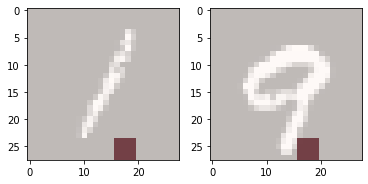

<Figure size 432x288 with 0 Axes>

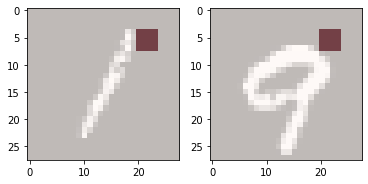

<Figure size 432x288 with 0 Axes>

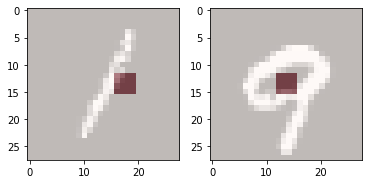

<Figure size 432x288 with 0 Axes>

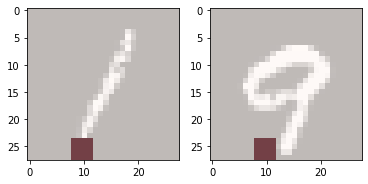

<Figure size 432x288 with 0 Axes>

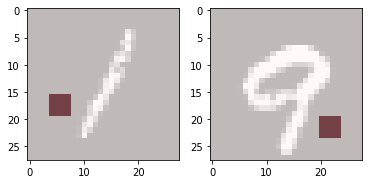

<Figure size 432x288 with 0 Axes>

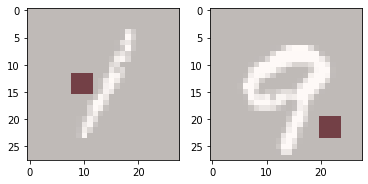

<Figure size 432x288 with 0 Axes>

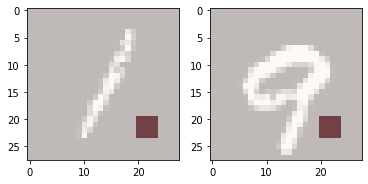

<Figure size 432x288 with 0 Axes>

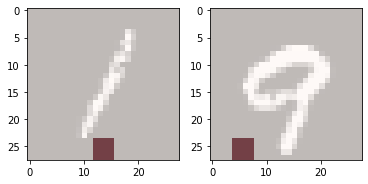

<Figure size 432x288 with 0 Axes>

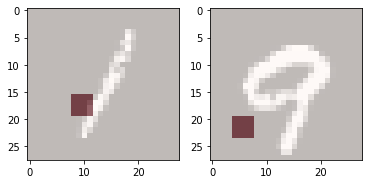

<Figure size 432x288 with 0 Axes>

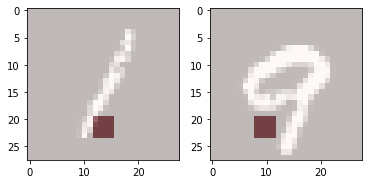

<Figure size 432x288 with 0 Axes>

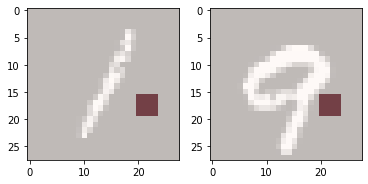

<Figure size 432x288 with 0 Axes>

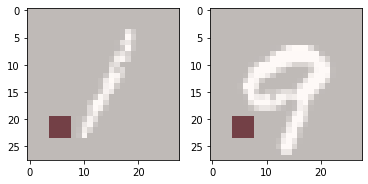

<Figure size 432x288 with 0 Axes>

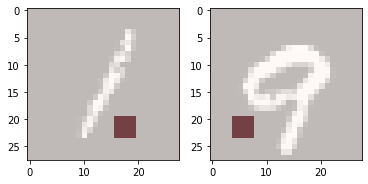

<Figure size 432x288 with 0 Axes>

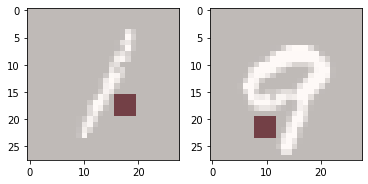

In [27]:
OTHER_IDX = 1290
ref_img = imgs[IDX:IDX+1]
other_img = imgs[OTHER_IDX:OTHER_IDX+1]
patched_ref = patch_image(ref_img)
other_repr = patch_representations_numpy[OTHER_IDX]

for i in ordered_norms:
    hm_ref = torch.zeros((1, 49, 1, 4, 4))
    hm_other = torch.zeros((1, 49, 1, 4, 4))
    
    hm_ref[0, i, 0, :, :] = 1.0
    
    curr_patch_repr = curr_repr[i:i+1]
    
    diffs = np.linalg.norm(other_repr - curr_patch_repr, axis=1)
    closest_patch = np.argmin(diffs)
    hm_other[0, closest_patch, 0, :, :] = 1.0
    
    plt.figure(i+1)
    fig, axis = plt.subplots(1, 2)
    
    axis[0].imshow(ref_img[0,0].detach().numpy(), cmap='gray', alpha=0.5)
    axis[0].imshow(fold_img(hm_ref)[0,0].detach().numpy(), cmap='Reds', alpha=0.5)
    
    
    axis[1].imshow(other_img[0,0].detach().numpy(), cmap='gray', alpha=0.5)
    axis[1].imshow(fold_img(hm_other)[0,0].detach().numpy(), cmap='Reds', alpha=0.5)
    
    plt.show()

/home/phineas/anaconda3/envs/kme_net/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


<Figure size 432x288 with 0 Axes>

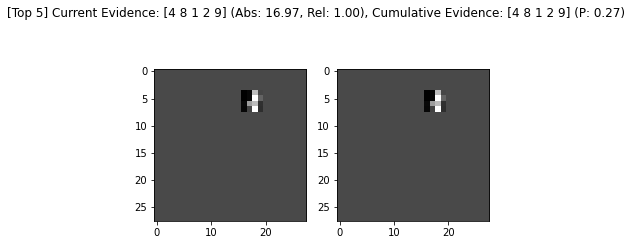

<Figure size 432x288 with 0 Axes>

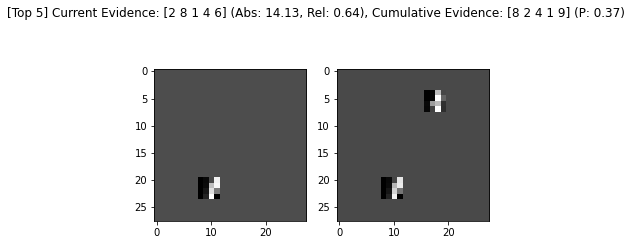

<Figure size 432x288 with 0 Axes>

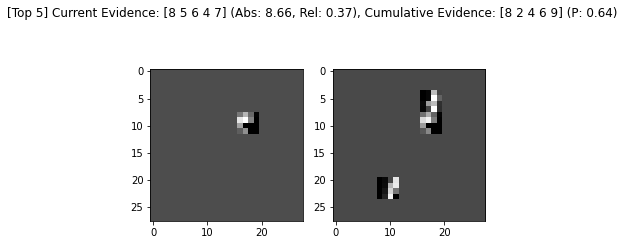

<Figure size 432x288 with 0 Axes>

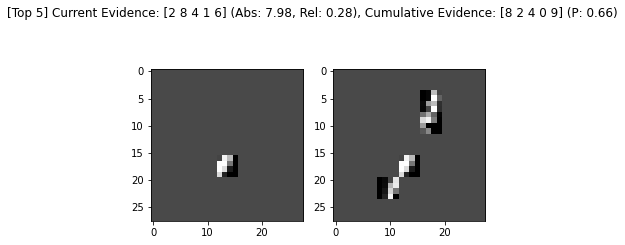

<Figure size 432x288 with 0 Axes>

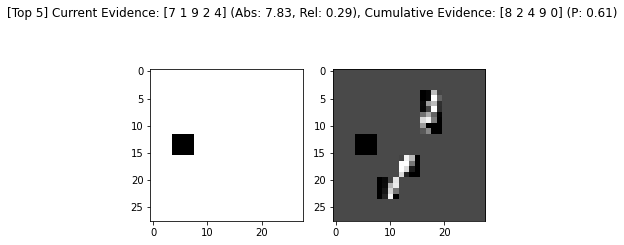

<Figure size 432x288 with 0 Axes>

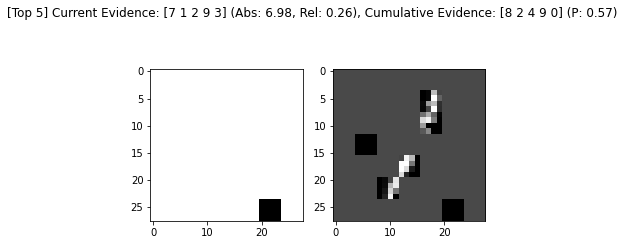

<Figure size 432x288 with 0 Axes>

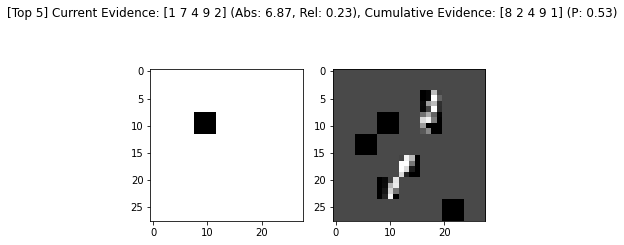

<Figure size 432x288 with 0 Axes>

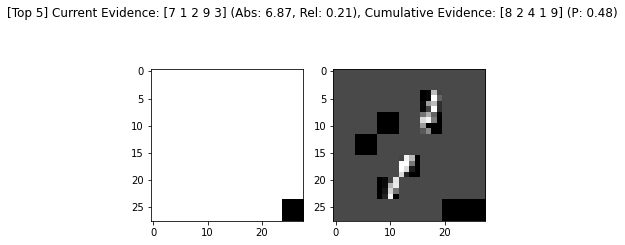

<Figure size 432x288 with 0 Axes>

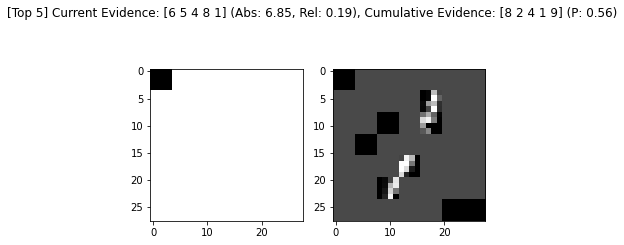

<Figure size 432x288 with 0 Axes>

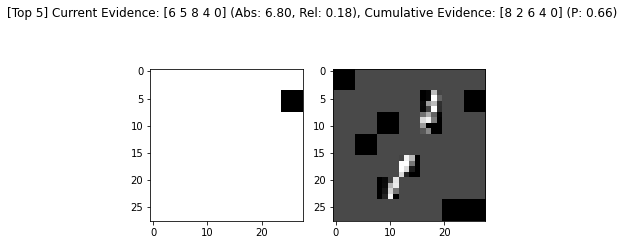

<Figure size 432x288 with 0 Axes>

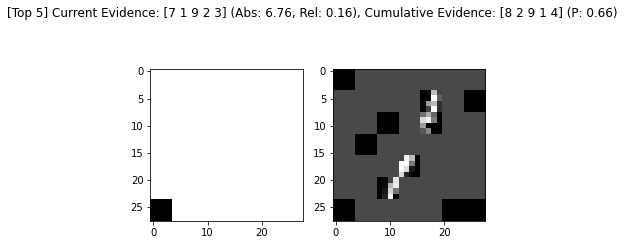

<Figure size 432x288 with 0 Axes>

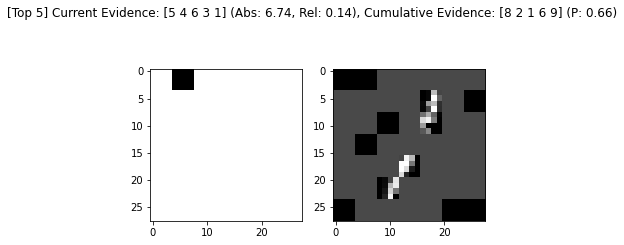

<Figure size 432x288 with 0 Axes>

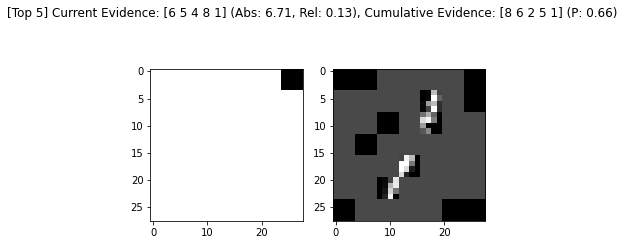

<Figure size 432x288 with 0 Axes>

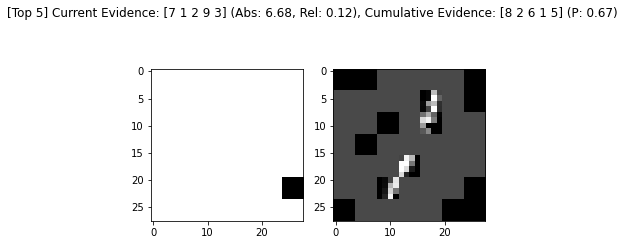

<Figure size 432x288 with 0 Axes>

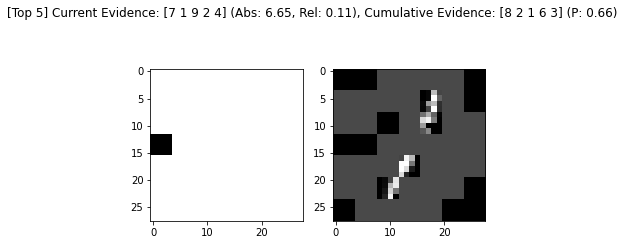

<Figure size 432x288 with 0 Axes>

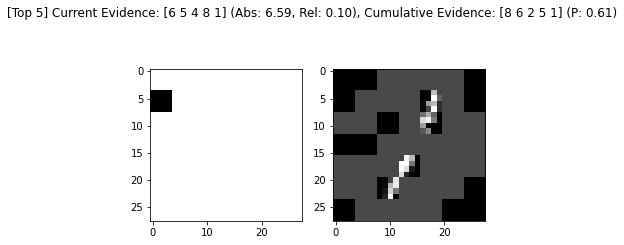

<Figure size 432x288 with 0 Axes>

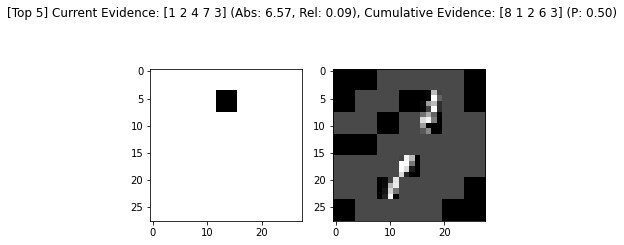

<Figure size 432x288 with 0 Axes>

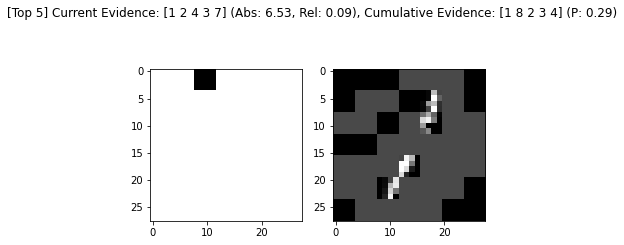

<Figure size 432x288 with 0 Axes>

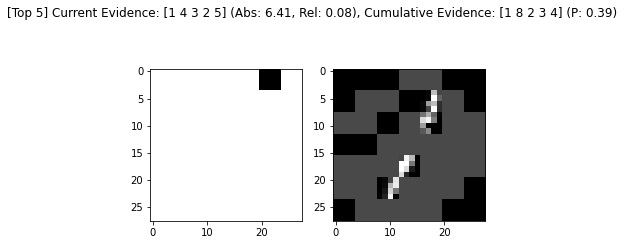

<Figure size 432x288 with 0 Axes>

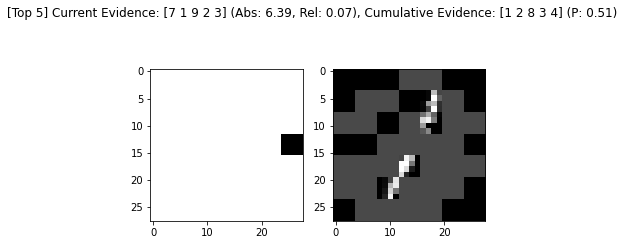

<Figure size 432x288 with 0 Axes>

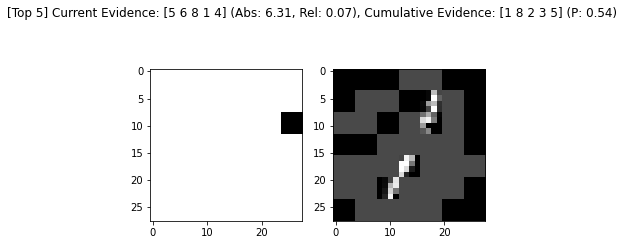

<Figure size 432x288 with 0 Axes>

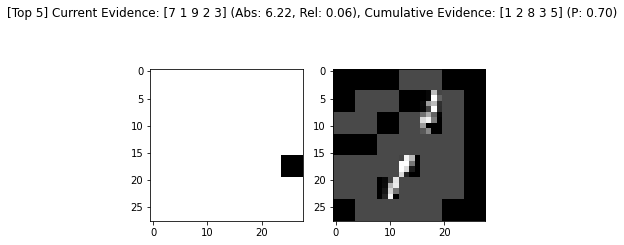

<Figure size 432x288 with 0 Axes>

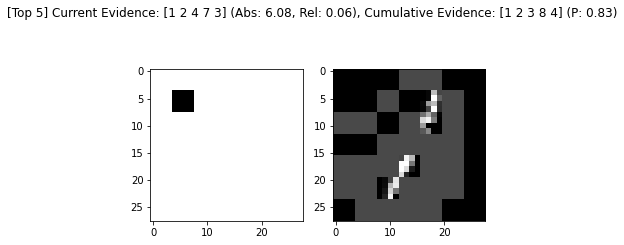

<Figure size 432x288 with 0 Axes>

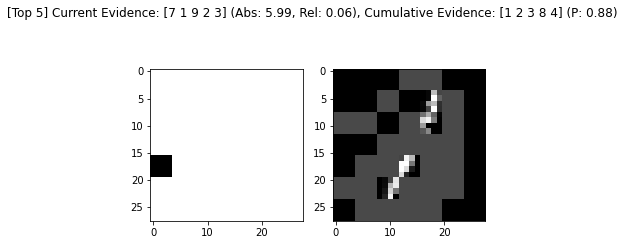

<Figure size 432x288 with 0 Axes>

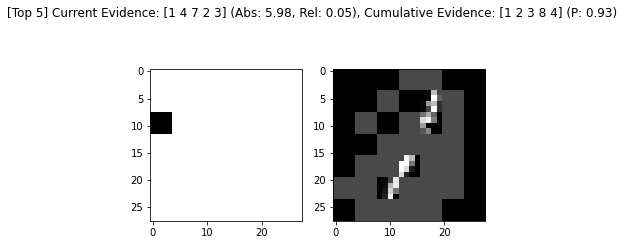

<Figure size 432x288 with 0 Axes>

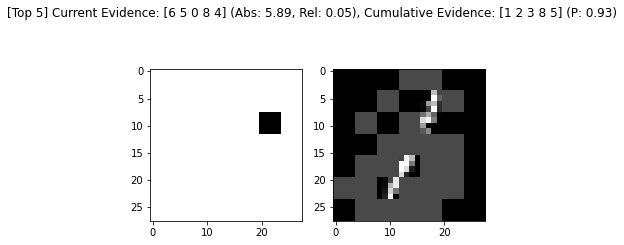

<Figure size 432x288 with 0 Axes>

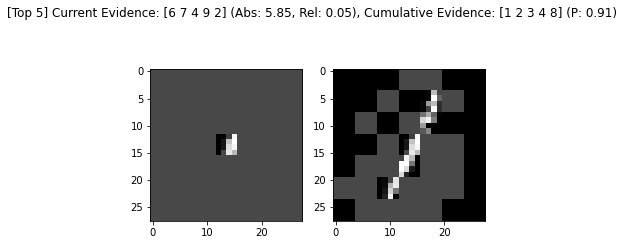

<Figure size 432x288 with 0 Axes>

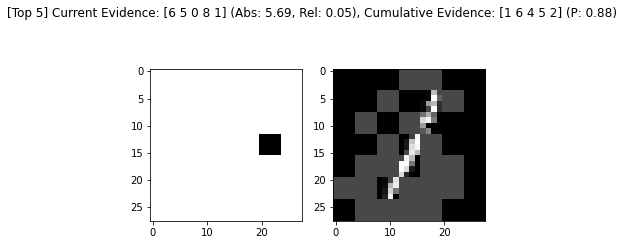

<Figure size 432x288 with 0 Axes>

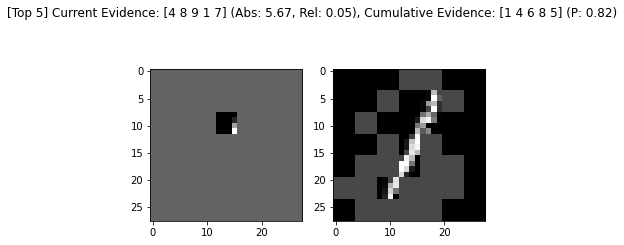

<Figure size 432x288 with 0 Axes>

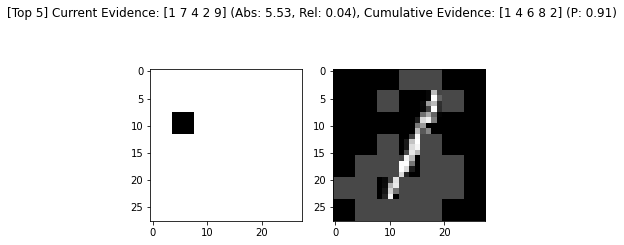

<Figure size 432x288 with 0 Axes>

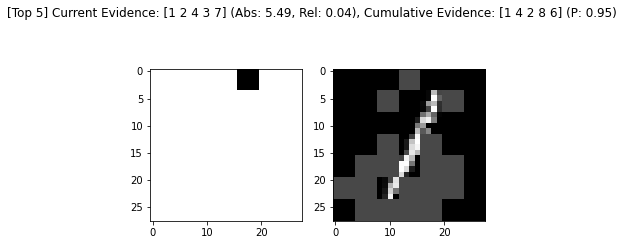

<Figure size 432x288 with 0 Axes>

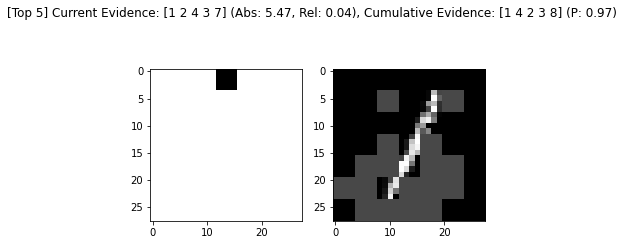

<Figure size 432x288 with 0 Axes>

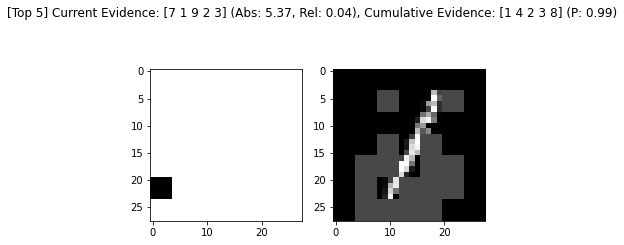

<Figure size 432x288 with 0 Axes>

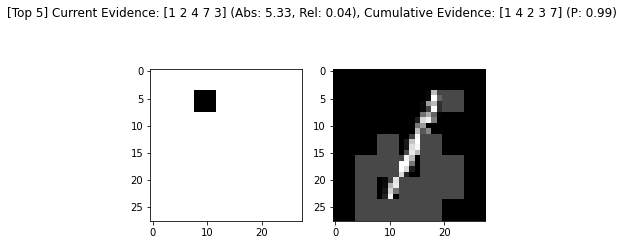

<Figure size 432x288 with 0 Axes>

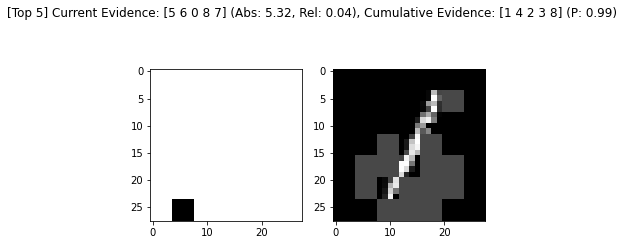

<Figure size 432x288 with 0 Axes>

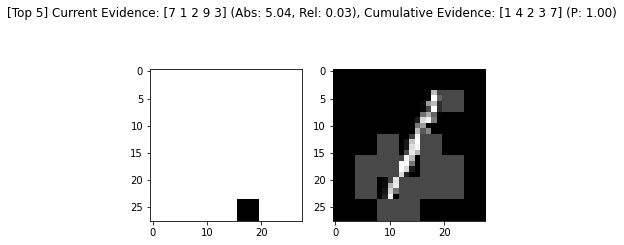

<Figure size 432x288 with 0 Axes>

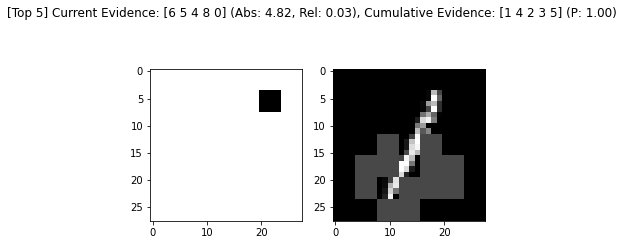

<Figure size 432x288 with 0 Axes>

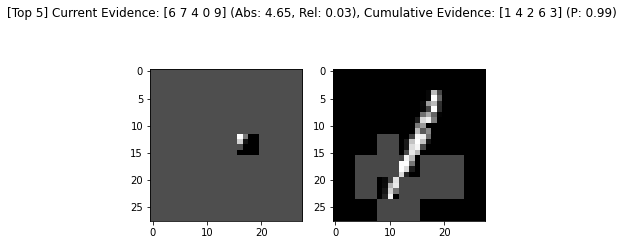

<Figure size 432x288 with 0 Axes>

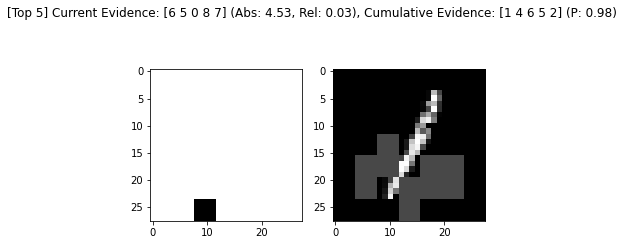

<Figure size 432x288 with 0 Axes>

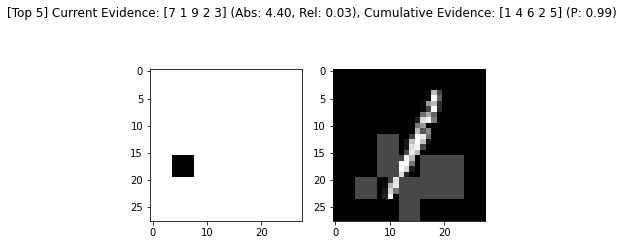

<Figure size 432x288 with 0 Axes>

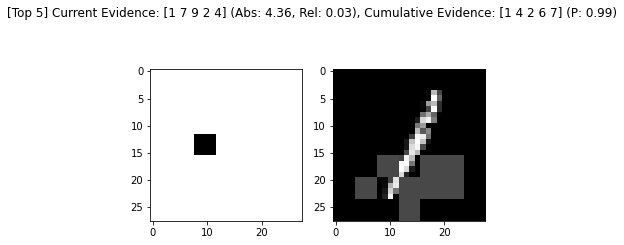

<Figure size 432x288 with 0 Axes>

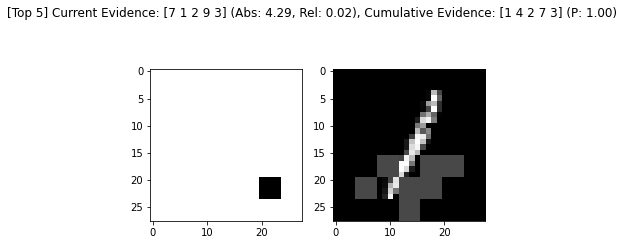

<Figure size 432x288 with 0 Axes>

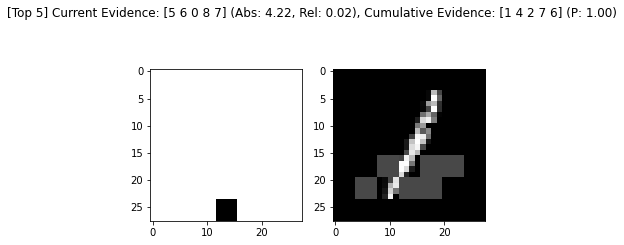

<Figure size 432x288 with 0 Axes>

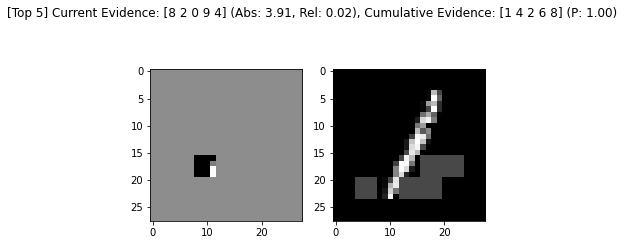

<Figure size 432x288 with 0 Axes>

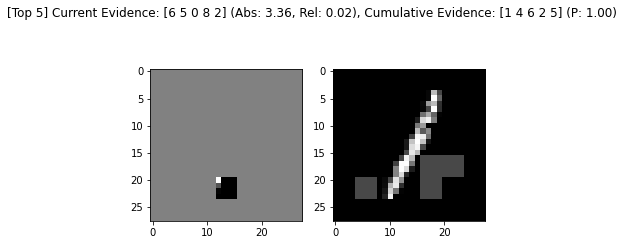

<Figure size 432x288 with 0 Axes>

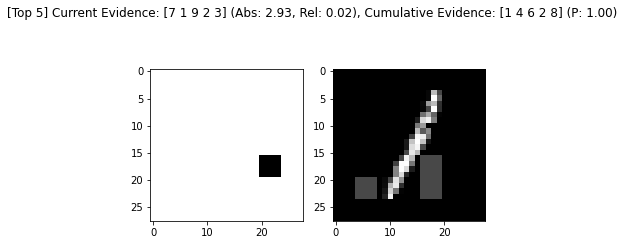

<Figure size 432x288 with 0 Axes>

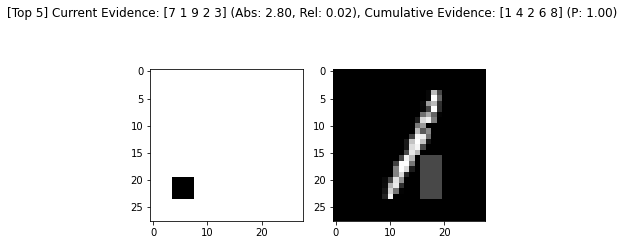

<Figure size 432x288 with 0 Axes>

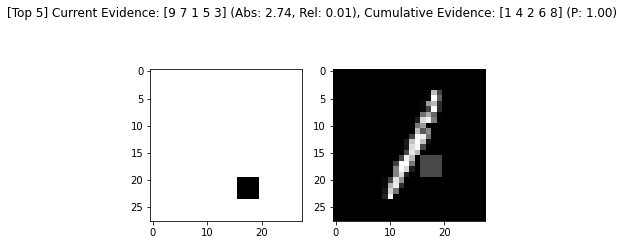

<Figure size 432x288 with 0 Axes>

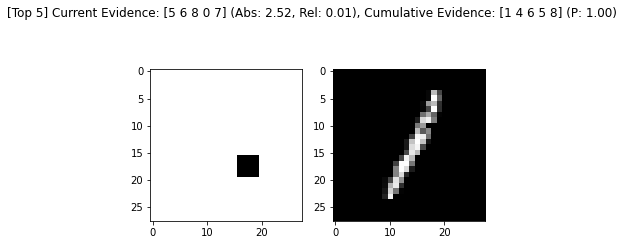

In [28]:
image = torch.ones((1, 49, 1, 4, 4))*0.5
ref_img = imgs[IDX:IDX+1]
patched_ref = patch_image(ref_img)
for i in range(49):
    isolated_image = torch.ones((1, 49, 1, 4, 4))*0.5
    curr_info = kme_net._classifier(torch.FloatTensor(curr_repr[ordered_norms[i:i+1],:]))
    curr_info = curr_info.topk(5).indices[0].detach().numpy()
    cum_repr = np.sum(curr_repr[ordered_norms[:i+1],:], axis=0)
    n = np.linalg.norm(cum_repr)
    cum_info = kme_net._classifier(torch.FloatTensor(np.sum(curr_repr[ordered_norms[:i+1],:], axis=0)).unsqueeze(0))
    odds_ratio = torch.nn.functional.softmax(cum_info).max()
    cum_info = cum_info.topk(5).indices[0].detach().numpy()
    image[0,ordered_norms[i],:, :, :] = patched_ref[0,ordered_norms[i],:, :, :]
    isolated_image[0,ordered_norms[i],:, :, :] = patched_ref[0,ordered_norms[i],:, :, :]
    plt.figure(i+1)
    fig, axis = plt.subplots(1, 2)
    fig.suptitle('[Top 5] Current Evidence: {} (Abs: {:.2f}, Rel: {:.2f}), Cumulative Evidence: {} (P: {:.2f})'.format(curr_info, norms[ordered_norms[i]], norms[ordered_norms[i]]/n ,cum_info, odds_ratio))
    axis[0].imshow(fold_img(isolated_image)[0,0].detach().numpy(), cmap='gray')
    axis[1].imshow(fold_img(image)[0,0].detach().numpy(), cmap='gray')
    plt.show()

In [29]:
np.linalg.norm(R, axis=0)

array([16.96513  , 14.1276045,  8.6618805,  7.977246 ,  7.833732 ,
        6.982673 ,  6.8737364,  6.866507 ,  6.8471637,  6.804956 ,
        6.7555704,  6.741864 ,  6.708006 ,  6.675214 ,  6.6499515,
        6.58957  ,  6.573175 ,  6.5281253,  6.41094  ,  6.389517 ,
        6.3069634,  6.2193646,  6.081954 ,  5.990898 ,  5.982927 ,
        5.8938723,  5.8543677,  5.6947303,  5.668279 ,  5.531278 ,
        5.4896107,  5.4746013,  5.3684106,  5.328942 ,  5.3214884,
        5.0425577,  4.817156 ,  4.654054 ,  4.526296 ,  4.403189 ,
        4.3630114,  4.292789 ,  4.2247863,  3.9095912,  3.3621078,
        2.9349527,  2.8031504,  2.7414157,  2.5165844], dtype=float32)

In [30]:
np.linalg.norm(curr_repr.sum(axis=0))

186.74416

<AxesSubplot:>

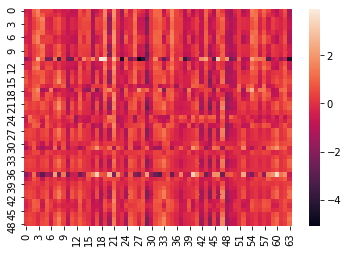

In [31]:
sns.heatmap(curr_repr)

<AxesSubplot:>

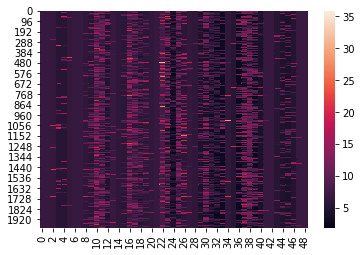

In [32]:
sns.heatmap(np.sqrt(np.sum(patch_representations_numpy**2, axis=2)))

In [33]:
most_important_patches = np.linalg.norm(curr_repr, axis=1).argsort()[::-1]

In [34]:
most_important_patches

array([11, 37, 18, 31, 22, 47, 16, 48,  0, 13, 42,  1,  6, 41, 21,  7, 10,
        2,  5, 27, 20, 34,  8, 28, 14, 19, 24, 26, 17, 15,  4,  3, 35,  9,
       43, 46, 12, 25, 44, 29, 23, 40, 45, 30, 38, 33, 36, 39, 32])

In [35]:
kme_net._classifier(torch.sum(patch_representations[100:101, [11, 13], :], dim=1)).argmax()

tensor(4)

## Find corresponding patches

In [78]:
np.where(ys == 1)

(array([   3,    5,    7,    8,   23,   24,   33,   55,   56,   72,   74,
          94,  102,  104,  108,  120,  125,  135,  141,  166,  176,  177,
         179,  181,  189,  192,  204,  209,  224,  243,  254,  280,  288,
         306,  308,  333,  343,  344,  346,  351,  353,  355,  356,  362,
         367,  407,  424,  426,  436,  443,  454,  464,  468,  469,  476,
         485,  486,  505,  517,  521,  527,  551,  557,  563,  564,  594,
         614,  616,  622,  629,  630,  632,  635,  644,  661,  669,  670,
         672,  673,  675,  689,  699,  705,  719,  725,  781,  782,  792,
         794,  824,  829,  831,  835,  836,  840,  841,  860,  861,  875,
         877,  880,  900,  911,  912,  920,  926,  929,  939,  974,  986,
         989, 1010, 1022, 1026, 1035, 1041, 1075, 1086, 1089, 1106, 1118,
        1124, 1163, 1179, 1190, 1198, 1209, 1238, 1244, 1247, 1252, 1255,
        1261, 1274, 1278, 1282, 1283, 1289, 1307, 1312, 1314, 1326, 1328,
        1337, 1347, 1348, 1349, 1350, 

In [79]:
np.where(ys == 7)

(array([   2,   11,   16,   17,   19,   44,   49,   60,   65,   83,   92,
         122,  126,  131,  139,  172,  174,  178,  230,  232,  236,  240,
         242,  258,  259,  283,  291,  303,  304,  312,  314,  326,  348,
         350,  366,  372,  376,  380,  385,  390,  404,  411,  413,  439,
         442,  446,  448,  460,  465,  489,  491,  496,  510,  511,  514,
         526,  547,  549,  574,  599,  608,  612,  617,  647,  657,  658,
         662,  684,  700,  703,  704,  707,  708,  729,  740,  767,  772,
         802,  818,  830,  849,  866,  873,  874,  883,  893,  907,  914,
         931,  947,  955,  969,  979,  980,  981,  984,  997, 1003, 1008,
        1012, 1023, 1033, 1039, 1047, 1051, 1057, 1063, 1066, 1080, 1091,
        1098, 1100, 1102, 1107, 1109, 1110, 1111, 1113, 1134, 1136, 1139,
        1144, 1148, 1167, 1170, 1171, 1177, 1185, 1188, 1202, 1205, 1207,
        1208, 1213, 1226, 1231, 1232, 1236, 1237, 1245, 1249, 1258, 1272,
        1276, 1306, 1310, 1311, 1325, 

In [95]:
IDX_1 = 2
IDX_2 = 1996

patches_1 = patch_representations_numpy[IDX_1]
patches_2 = patch_representations_numpy[IDX_2]

In [96]:
row_idx, col_idx = match_single_patches(patches_1, patches_2)
assignments = {k: v for k, v in zip(row_idx, col_idx)}

<Figure size 432x288 with 0 Axes>

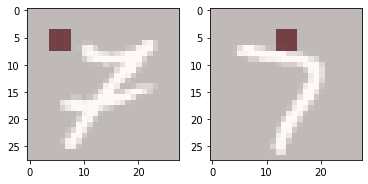

<Figure size 432x288 with 0 Axes>

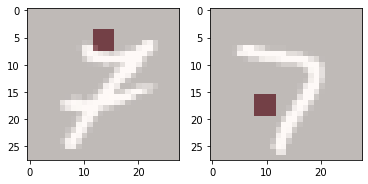

<Figure size 432x288 with 0 Axes>

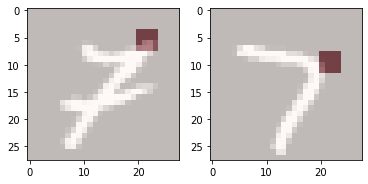

<Figure size 432x288 with 0 Axes>

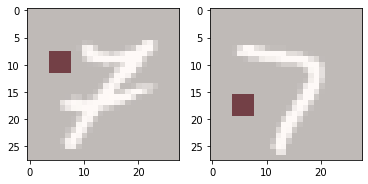

<Figure size 432x288 with 0 Axes>

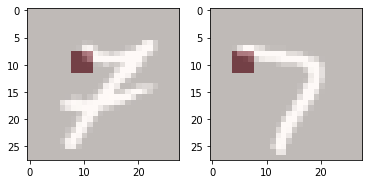

<Figure size 432x288 with 0 Axes>

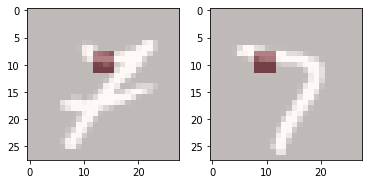

<Figure size 432x288 with 0 Axes>

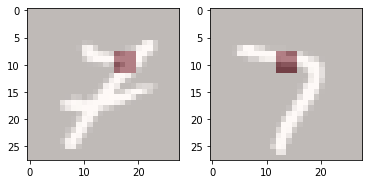

<Figure size 432x288 with 0 Axes>

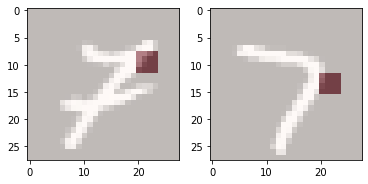

<Figure size 432x288 with 0 Axes>

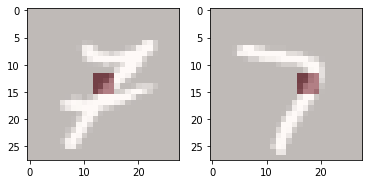

<Figure size 432x288 with 0 Axes>

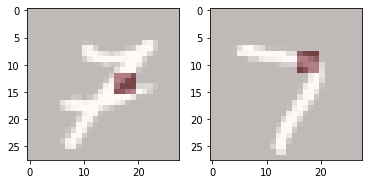

<Figure size 432x288 with 0 Axes>

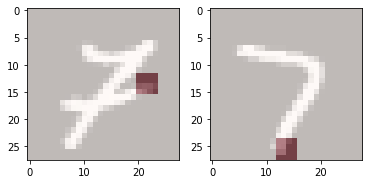

<Figure size 432x288 with 0 Axes>

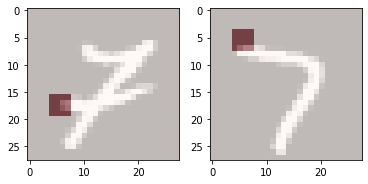

<Figure size 432x288 with 0 Axes>

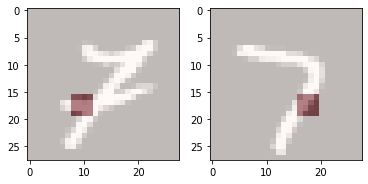

<Figure size 432x288 with 0 Axes>

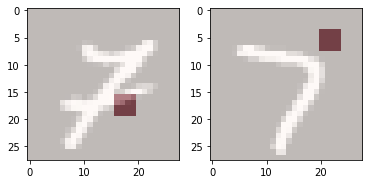

<Figure size 432x288 with 0 Axes>

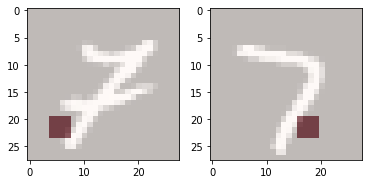

<Figure size 432x288 with 0 Axes>

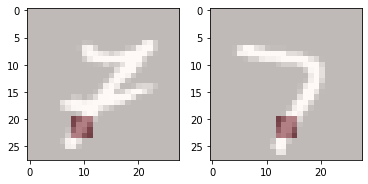

<Figure size 432x288 with 0 Axes>

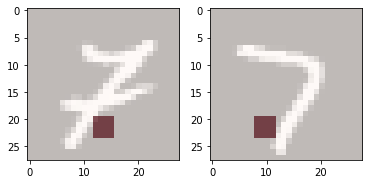

<Figure size 432x288 with 0 Axes>

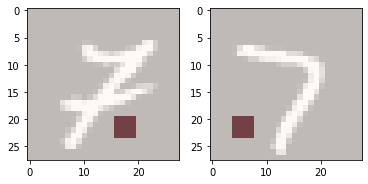

<Figure size 432x288 with 0 Axes>

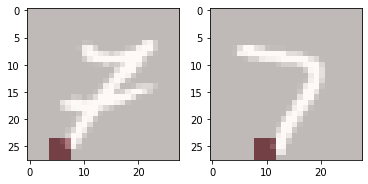

<Figure size 432x288 with 0 Axes>

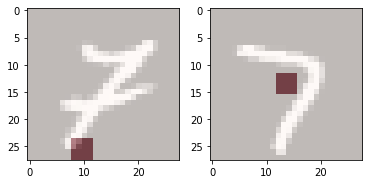

<Figure size 432x288 with 0 Axes>

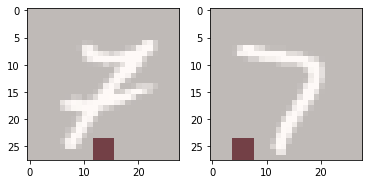

In [97]:
ref_img = imgs[IDX_1:IDX_1+1]
other_img = imgs[IDX_2:IDX_2+1]
patched_ref = patch_image(ref_img)
other_repr = patch_representations_numpy[IDX_2]

c = 1

for i1, i2 in assignments.items():
    if i1 == i2:
        continue
    hm_ref = torch.zeros((1, 49, 1, 4, 4))
    hm_other = torch.zeros((1, 49, 1, 4, 4))
    
    hm_ref[0, i1, 0, :, :] = 1.0
    hm_other[0, i2, 0, :, :] = 1.0
    
    plt.figure(c)
    fig, axis = plt.subplots(1, 2)
    
    axis[0].imshow(ref_img[0,0].detach().numpy(), cmap='gray', alpha=0.5)
    axis[0].imshow(fold_img(hm_ref)[0,0].detach().numpy(), cmap='Reds', alpha=0.5)
    
    
    axis[1].imshow(other_img[0,0].detach().numpy(), cmap='gray', alpha=0.5)
    axis[1].imshow(fold_img(hm_other)[0,0].detach().numpy(), cmap='Reds', alpha=0.5)
    
    plt.show()
    c = c + 1